In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## load and visualize

In [2]:
# tool function
# pie_average
def pie_average_wedge(Qx, Qy, I, dI=None, *,
                      center_angle_rad=0.0,
                      half_width_rad=np.deg2rad(5.0),
                      nbins=120,
                      Qmin=None, Qmax=None,
                      use_weighted=True,
                      return_counts=False):
    """
    Pie-average intensity in a wedge around center_angle_rad.
    Angles are defined in standard polar coordinates: theta = arctan2(Qy, Qx).

    Parameters
    ----------
    Qx, Qy, I : 1D arrays
    dI : 1D array or None
        If provided and use_weighted=True, weights = 1/dI^2.
    center_angle_rad : float
        Wedge center angle. para ~ 0, perp ~ pi/2.
    half_width_rad : float
        Half wedge width (e.g., 5 degrees => +/-5 deg).
    nbins : int
        Number of radial Q bins.
    Qmin, Qmax : float or None
        Radial range. If None, inferred from wedge-selected points.
    use_weighted : bool
        If True and dI is provided, compute weighted mean.
        Else use simple mean.
    return_counts : bool
        If True, also return counts per bin.

    Returns
    -------
    Q_centers : 1D array
    I_binned  : 1D array
    dI_binned : 1D array (if dI provided), else None
    counts    : 1D array (if return_counts=True)
    """
    Qx = np.asarray(Qx); Qy = np.asarray(Qy); I = np.asarray(I)

    # Basic finite mask
    m = np.isfinite(Qx) & np.isfinite(Qy) & np.isfinite(I)
    if dI is not None:
        dI = np.asarray(dI)
        m &= np.isfinite(dI) & (dI > 0)

    Qx, Qy, I = Qx[m], Qy[m], I[m]
    dI_use = dI[m] if dI is not None else None

    Q = np.sqrt(Qx**2 + Qy**2)
    theta = np.arctan2(Qy, Qx)  # (-pi, pi]

    # Smallest signed angular difference in [-pi, pi]
    dtheta = (theta - center_angle_rad + np.pi) % (2*np.pi) - np.pi
    mw = np.abs(dtheta) <= half_width_rad

    Qw, Iw = Q[mw], I[mw]
    dIw = dI_use[mw] if dI_use is not None else None

    if Qw.size == 0:
        raise ValueError("No points found in wedge; widen half_width_rad or check data orientation.")

    if Qmin is None: Qmin = np.nanmin(Qw)
    if Qmax is None: Qmax = np.nanmax(Qw)
    if Qmax <= Qmin:
        raise ValueError("Invalid Q range after wedge selection.")

    edges = np.linspace(Qmin, Qmax, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_id = np.digitize(Qw, edges) - 1
    good = (bin_id >= 0) & (bin_id < nbins)

    bin_id = bin_id[good]
    Iw = Iw[good]
    if dIw is not None:
        dIw = dIw[good]

    counts = np.bincount(bin_id, minlength=nbins)

    if (dIw is not None) and use_weighted:
        w = 1.0 / (dIw**2)
        sumw = np.bincount(bin_id, weights=w, minlength=nbins)
        sumwI = np.bincount(bin_id, weights=w*Iw, minlength=nbins)
        I_binned = np.divide(sumwI, sumw, out=np.full(nbins, np.nan), where=(sumw > 0))

        # standard error of weighted mean (measurement-noise-only)
        dI_binned = np.divide(1.0, np.sqrt(sumw), out=np.full(nbins, np.nan), where=(sumw > 0))
    else:
        sumI = np.bincount(bin_id, weights=Iw, minlength=nbins)
        I_binned = np.divide(sumI, counts, out=np.full(nbins, np.nan), where=(counts > 0))
        dI_binned = None
        if dIw is not None:
            # conservative: combine reported dI by RMS / sqrt(N)
            sum_dI2 = np.bincount(bin_id, weights=dIw**2, minlength=nbins)
            dI_binned = np.divide(np.sqrt(sum_dI2), counts, out=np.full(nbins, np.nan), where=(counts > 0))

    # Keep only bins with data
    keep = counts > 0
    out = (centers[keep], I_binned[keep])
    if dI is not None:
        out = out + (dI_binned[keep],)
    if return_counts:
        out = out + (counts[keep],)
    return out


# match eqsans curves
def _powerlaw_fit_loglog(Q, I):
    """
    Fit log(I) = b + m*log(Q). Returns (m, b).
    """
    x = np.log(Q)
    y = np.log(I)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, b

def _vertical_shift_factor_powerlaw(
    Q_ref, I_ref,
    Q_seg, I_seg,
    q_overlap=None,
    min_points=12,
    q_pad=0.0,
):
    """
    Compute multiplicative factor s so that s*I_seg matches power-law extrapolation
    of I_ref in the overlap region.

    q_overlap:
      - None: auto overlap = intersection of Q ranges
      - (qmin, qmax): explicit overlap window
    q_pad: shrink overlap window by a fraction of its width (0..0.49) to avoid edge issues.
    """
    # sanitize: positive only for log fits
    mask_ref = (Q_ref > 0) & (I_ref > 0) & np.isfinite(Q_ref) & np.isfinite(I_ref)
    mask_seg = (Q_seg > 0) & (I_seg > 0) & np.isfinite(Q_seg) & np.isfinite(I_seg)
    Qr, Ir = Q_ref[mask_ref], I_ref[mask_ref]
    Qs, Is = Q_seg[mask_seg], I_seg[mask_seg]

    if Qr.size < min_points or Qs.size < min_points:
        return 1.0  # not enough data to be meaningful

    # overlap window
    if q_overlap is None:
        qmin = max(np.min(Qr), np.min(Qs))
        qmax = min(np.max(Qr), np.max(Qs))
    else:
        qmin, qmax = q_overlap

    if not (np.isfinite(qmin) and np.isfinite(qmax)) or qmax <= qmin:
        return 1.0

    # optional shrink overlap window
    width = qmax - qmin
    qmin2 = qmin + q_pad * width
    qmax2 = qmax - q_pad * width
    if qmax2 <= qmin2:
        return 1.0

    # take overlap points
    r_ol = (Qr >= qmin2) & (Qr <= qmax2)
    s_ol = (Qs >= qmin2) & (Qs <= qmax2)

    if np.count_nonzero(r_ol) < min_points or np.count_nonzero(s_ol) < min_points:
        print("Warning: not enough overlap points for vertical shift fit.")
        return 1.0

    Qr_ol, Ir_ol = Qr[r_ol], Ir[r_ol]
    Qs_ol, Is_ol = Qs[s_ol], Is[s_ol]

    # fit power law on reference overlap
    m, b = _powerlaw_fit_loglog(Qr_ol, Ir_ol)

    # predict reference intensity at segment Q points (extrapolated power-law)
    Iref_fit_on_seg = np.exp(b + m * np.log(Qs_ol))

    # compute scale in log space (geometric mean ratio)
    log_ratio = np.log(Iref_fit_on_seg) - np.log(Is_ol)
    s = float(np.exp(np.mean(log_ratio)))

    if not np.isfinite(s) or s <= 0:
        s = 1.0
    return s

def concat_with_optional_powerlaw_shift(
    Q_lq, I_lq, dI_lq,
    Q_mq, I_mq, dI_mq,
    Q_hq, I_hq, dI_hq,
    do_shift=True,
    overlap_mq=None,   # (qmin,qmax) or None for auto
    overlap_hq=None,   # (qmin,qmax) or None for auto
    min_points=12,
    q_pad=0.0,
):
    """
    Low-Q is the base. Optionally shift MQ to match LQ, then shift HQ to match (LQ+MQ).
    Returns concatenated (Q, I, dI) and a dict of applied scale factors.
    """
    # start with low-Q as reference
    Q_ref = np.asarray(Q_lq)
    I_ref = np.asarray(I_lq)
    dI_ref = np.asarray(dI_lq)

    factors = {"mq": 1.0, "hq": 1.0}

    # shift MQ
    Q_mq = np.asarray(Q_mq); I_mq = np.asarray(I_mq); dI_mq = np.asarray(dI_mq)
    if do_shift:
        s_mq = _vertical_shift_factor_powerlaw(
            Q_ref, I_ref, Q_mq, I_mq,
            q_overlap=overlap_mq,
            min_points=min_points,
            q_pad=q_pad,
        )
        factors["mq"] = s_mq
        I_mq = I_mq * s_mq
        dI_mq = dI_mq * s_mq

    # update reference by concatenating LQ+MQ (temporarily) for HQ fit
    Q_ref2 = np.concatenate([Q_ref, Q_mq])
    I_ref2 = np.concatenate([I_ref, I_mq])
    dI_ref2 = np.concatenate([dI_ref, dI_mq])

    # shift HQ
    Q_hq = np.asarray(Q_hq); I_hq = np.asarray(I_hq); dI_hq = np.asarray(dI_hq)
    if do_shift:
        s_hq = _vertical_shift_factor_powerlaw(
            Q_ref2, I_ref2, Q_hq, I_hq,
            q_overlap=overlap_hq,
            min_points=min_points,
            q_pad=q_pad,
        )
        factors["hq"] = s_hq
        I_hq = I_hq * s_hq
        dI_hq = dI_hq * s_hq

    # final concatenation
    Q_all  = np.concatenate([Q_ref,  Q_mq,  Q_hq])
    I_all  = np.concatenate([I_ref,  I_mq,  I_hq])
    dI_all = np.concatenate([dI_ref, dI_mq, dI_hq])

    return Q_all, I_all, dI_all, factors

# concatnated error organizer
def organize_error_continuous_1d(
    Q, dI,
    *,
    half_window=10,
    mode="invvar",
    clamp_factor=1.1,
):
    """
    Construct a continuous error curve dI(Q) dominated by smallest errors.

    Parameters
    ----------
    Q, dI : 1D arrays (sorted by Q, Q>0)
    half_window : int
        Number of neighbors on each side in log-Q index space.
    mode : {"invvar", "min"}
        "invvar": inverse-variance pooling (recommended)
        "min":    hard minimum envelope
    clamp_factor : float
        Final dI will not exceed clamp_factor * local minimum dI.

    Returns
    -------
    dI_new : 1D array, same shape as dI
    """

    Q = np.asarray(Q)
    dI = np.asarray(dI)

    if np.any(Q <= 0):
        raise ValueError("Q must be positive.")
    if np.any(~np.isfinite(dI)) or np.any(dI <= 0):
        raise ValueError("dI must be finite and positive.")

    n = Q.size
    logQ = np.log(Q)
    logdI = np.log(dI)

    dI_out = np.full(n, np.nan)

    for i in range(n):
        lo = max(0, i - half_window)
        hi = min(n, i + half_window + 1)

        local_dI = dI[lo:hi]
        m = np.isfinite(local_dI)

        if np.count_nonzero(m) < 3:
            continue

        if mode == "min":
            dI_loc = np.min(local_dI[m])
        else:  # inverse-variance pooling
            w = 1.0 / local_dI[m]**2
            dI_loc = 1.0 / np.sqrt(np.sum(w))

        dI_out[i] = dI_loc

    # smooth in log-space (median filter)
    logdI_smooth = logdI.copy()
    for i in range(n):
        lo = max(0, i - half_window)
        hi = min(n, i + half_window + 1)
        vals = np.log(dI_out[lo:hi])
        vals = vals[np.isfinite(vals)]
        if vals.size >= 3:
            logdI_smooth[i] = np.median(vals)

    dI_smooth = np.exp(logdI_smooth)

    # clamp so error is dominated by smallest local error
    dI_min_local = np.minimum.accumulate(dI)
    dI_final = np.minimum(dI_smooth, clamp_factor * dI_min_local)

    return dI_final

# fit porod bg
def fit_porod_background(Q, I, dI=None, *, qmin_fit=None, qmax_fit=None,
                         use_weighted=True, n_iter=2, clip_sigma=4.0):
    """
    Fit I(Q) = a*Q^-4 + I_bg on a high-Q window [qmin_fit, qmax_fit].

    Returns
    -------
    a, I_bg, fit_mask
    """
    Q = np.asarray(Q); I = np.asarray(I)
    m = np.isfinite(Q) & np.isfinite(I) & (Q > 0)

    if dI is not None:
        dI = np.asarray(dI)
        m &= np.isfinite(dI) & (dI > 0)

    if qmin_fit is None:
        qmin_fit = np.quantile(Q[m], 0.85)  # default: top 15% of Q
    if qmax_fit is None:
        qmax_fit = np.max(Q[m])

    m &= (Q >= qmin_fit) & (Q <= qmax_fit)
    if np.count_nonzero(m) < 8:
        raise ValueError("Not enough points in high-Q fit window; adjust qmin_fit/qmax_fit.")

    # Design matrix for linear least squares in parameters [a, I_bg]
    X = np.vstack([Q[m]**(-4), np.ones(np.count_nonzero(m))]).T
    y = I[m]

    if (dI is not None) and use_weighted:
        w = 1.0 / (dI[m]**2)
    else:
        w = np.ones_like(y)

    # iterative sigma-clip on residuals (in intensity units)
    keep = np.ones_like(y, dtype=bool)
    for _ in range(max(1, n_iter)):
        Xk = X[keep]
        yk = y[keep]
        wk = w[keep]

        # Weighted normal equations: (X^T W X) beta = X^T W y
        W = wk
        XtW = Xk.T * W
        beta = np.linalg.lstsq(XtW @ Xk, XtW @ yk, rcond=None)[0]
        a, I_bg = float(beta[0]), float(beta[1])

        # residuals for clipping
        yhat = X @ beta
        resid = y - yhat
        # robust scale estimate
        mad = np.median(np.abs(resid[keep] - np.median(resid[keep])))
        sigma = 1.4826 * mad if mad > 0 else np.std(resid[keep])
        if not np.isfinite(sigma) or sigma <= 0:
            break
        keep = np.abs(resid) <= clip_sigma * sigma

        # ensure we don't clip too aggressively
        if np.count_nonzero(keep) < 6:
            keep[:] = True
            break

    # build full mask in original indexing for reporting
    fit_mask = np.zeros_like(Q, dtype=bool)
    idx_m = np.where(m)[0]
    fit_mask[idx_m] = keep

    return a, I_bg, fit_mask

def subtract_constant_background(I, dI, I_bg, *, floor_to_zero=False):
    """
    Subtract constant I_bg from I. dI unchanged (constant background subtraction).
    """
    I_corr = I - I_bg
    if floor_to_zero:
        I_corr = np.maximum(I_corr, 0.0)
    return I_corr, dI


Optimal epsilon: -0.38, Minimum loss: 0.04879313705014211


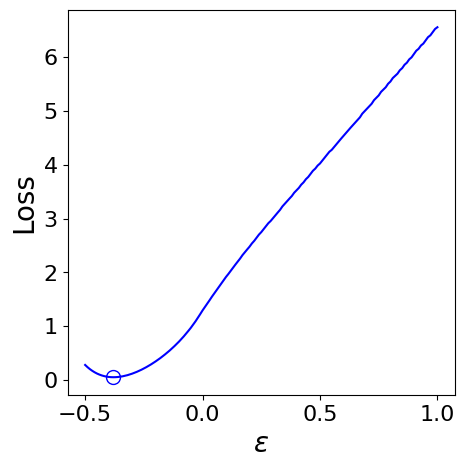

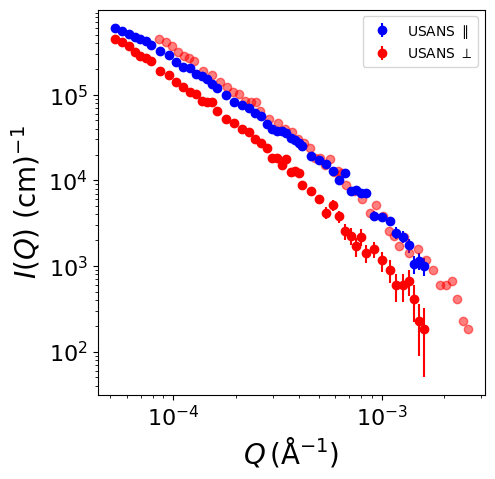

Low Q range: (-0.03395646, 0.03638733)
Mid Q range: (-0.08133716, 0.08950429)
High Q range: (-0.2799932, 0.3072851)


/tmp/ipykernel_1232119/2733394225.py:195: RuntimeWarning: invalid value encountered in log10
  c = ax.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_lq).astype(float))


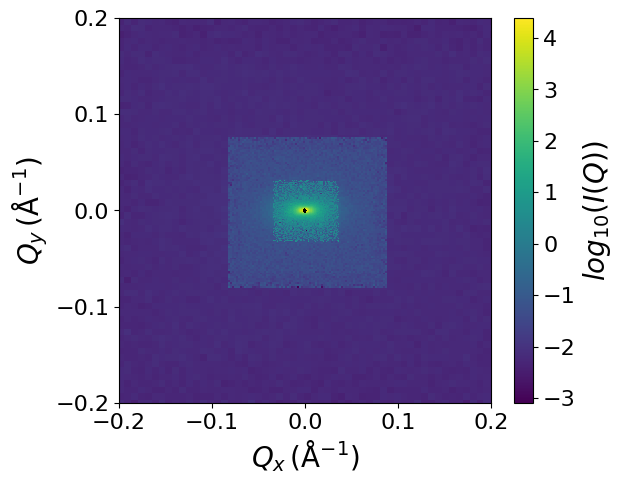

para factors: {'mq': 1.0613358813399818, 'hq': 2.922668095584892}
perp factors: {'mq': 1.170868331488444, 'hq': 3.2443141104836783}
PARA: a = 6.474857999816074e-05 I_bg = 0.2958353839478643
PERP: a = 1.2967033352555374e-05 I_bg = 0.3426623638572985


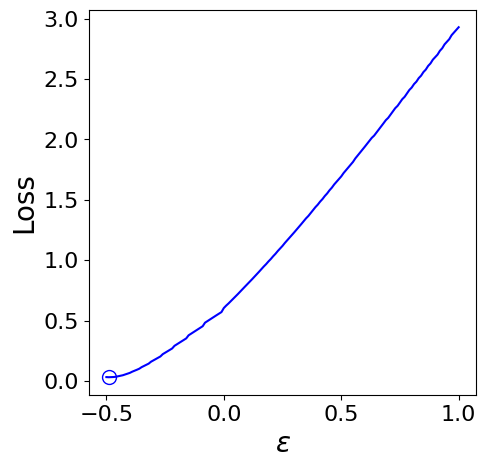

Optimal epsilon (SANS): -0.49, Minimum loss (SANS): 0.030541457622382202


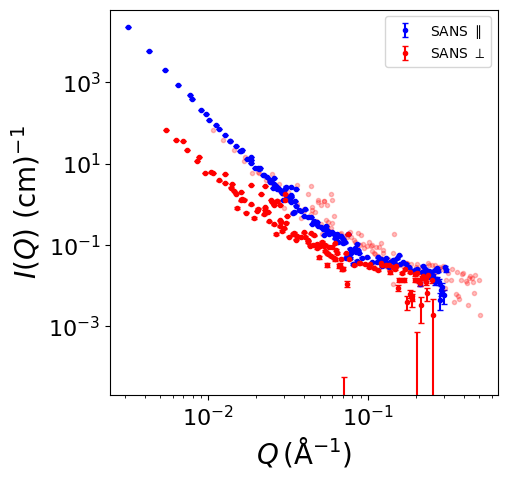

In [20]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

sample_id = "1"

filename_USANS_para = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_para_8mm.txt"
filename_USANS_perp = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_perp_8mm.txt"
filename_SANS_para_lq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_8m_Iqxqy.dat"
filename_SANS_para_mq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_inc_Iqxqy.dat"
filename_SANS_para_hq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf2_inc_Iqxqy.dat"
# load USANS data
data_USANS_para = np.genfromtxt(filename_USANS_para, skip_header=0, delimiter=',', filling_values=np.nan)
data_USANS_perp = np.genfromtxt(filename_USANS_perp, skip_header=0, delimiter=',', filling_values=np.nan)

Q_obs_usans_para = data_USANS_para[:, 0]
I_obs_usans_para = data_USANS_para[:, 1]
dI_obs_usans_para = data_USANS_para[:, 2]
Q_obs_usans_para_mask = Q_obs_usans_para > 5e-5
Q_obs_usans_para = Q_obs_usans_para[Q_obs_usans_para_mask]
I_obs_usans_para = I_obs_usans_para[Q_obs_usans_para_mask]
dI_obs_usans_para = dI_obs_usans_para[Q_obs_usans_para_mask]

Q_obs_usans_perp = data_USANS_perp[:, 0]
I_obs_usans_perp = data_USANS_perp[:, 1]
dI_obs_usans_perp = data_USANS_perp[:, 2]
Q_obs_usans_perp_mask = Q_obs_usans_perp > 5e-5
Q_obs_usans_perp = Q_obs_usans_perp[Q_obs_usans_perp_mask]
I_obs_usans_perp = I_obs_usans_perp[Q_obs_usans_perp_mask]
dI_obs_usans_perp = dI_obs_usans_perp[Q_obs_usans_perp_mask]

# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_usans_para = np.log(np.clip(I_obs_usans_para, 1e-300, None))
log_I_obs_usans_perp = np.log(np.clip(I_obs_usans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 3
coeffs_para = np.polyfit(Q_obs_usans_para, log_I_obs_usans_para, deg)
coeffs_perp = np.polyfit(Q_obs_usans_perp, log_I_obs_usans_perp, deg)

# Use an overlap Q grid for comparison
Q_min = max(Q_obs_usans_para.min(), Q_obs_usans_perp.min())
Q_max = min(Q_obs_usans_para.max(), Q_obs_usans_perp.max())
Q_ref = np.linspace(Q_min, Q_max, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_eps_loss(epsilon, Q_ref, coeffs_para, coeffs_perp,
                   Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, Q_ref[m])
    log_I_perp = np.polyval(coeffs_perp, Q_perp[m])

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list = np.linspace(-0.5, 1.0, 151)
loss_list = np.array([
    calculate_eps_loss(eps, Q_ref, coeffs_para, coeffs_perp,
                   Q_obs_usans_perp.min(), Q_obs_usans_perp.max())
    for eps in epsilon_list
])

optimal_epsilon = epsilon_list[np.nanargmin(loss_list)]
min_loss = np.nanmin(loss_list)

# Original smooth grid
Q_smooth = np.linspace(
    min(Q_obs_usans_para.min(), Q_obs_usans_perp.min()),
    max(Q_obs_usans_para.max(), Q_obs_usans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_para = np.polyval(coeffs_para, Q_smooth)
log_I_fit_perp = np.polyval(coeffs_perp, Q_smooth)

# Apply optimal stretch to PERP direction
Q_perp_stretched = (1 + optimal_epsilon) * Q_smooth
        
print(f"Optimal epsilon: {optimal_epsilon}, Minimum loss: {min_loss}")
    
# Find the optimal epsilon that minimizes the loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epsilon_list, loss_list, '-', color='blue')
ax.set_xlabel(r'$\epsilon$', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(optimal_epsilon, min_loss, 'bo', fillstyle='none', markersize=10)
plt.show()

# plot loaded USANS data
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(Q_obs_usans_para, I_obs_usans_para, yerr=dI_obs_usans_para, fmt='o', label='USANS $\parallel$', color='blue')
ax.errorbar(Q_obs_usans_perp, I_obs_usans_perp, yerr=dI_obs_usans_perp, fmt='o', label='USANS $\perp$', color='red')
# ax.plot(Q_smooth, np.exp(log_I_fit_para), '-', color='blue')
# ax.plot(Q_smooth, np.exp(log_I_fit_perp), '-', color='red')
# ax.plot(Q_smooth*(1 + optimal_epsilon), np.exp(log_I_fit_para), '--', color='green')
ax.plot(Q_obs_usans_perp/(1 + optimal_epsilon), I_obs_usans_perp, 'o', color='red', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()

# load SANS data
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_lq = np.genfromtxt(filename_SANS_para_lq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_lq = data_SANS_lq[:, 0]
Qy_obs_sans_lq = data_SANS_lq[:, 1]
Ixy_obs_sans_lq = data_SANS_lq[:, 2]
dI_obs_sans_lq = data_SANS_lq[:, 3]
unique_Qx_lq = np.unique(Qx_obs_sans_lq)
unique_Qy_lq = np.unique(Qy_obs_sans_lq)

# Create a grid
Qx_grid_lq, Qy_grid_lq = np.meshgrid(unique_Qx_lq, unique_Qy_lq)

# Initialize grid for intensity values with NaN
I_grid_lq = np.full(Qx_grid_lq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_lq)):
    x_idx = np.where(unique_Qx_lq == Qx_obs_sans_lq[i])[0][0]
    y_idx = np.where(unique_Qy_lq == Qy_obs_sans_lq[i])[0][0]
    I_grid_lq[y_idx, x_idx] = Ixy_obs_sans_lq[i]
    
# load SANS data (mq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_mq = np.genfromtxt(filename_SANS_para_mq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_mq = data_SANS_mq[:, 0]
Qy_obs_sans_mq = data_SANS_mq[:, 1]
Ixy_obs_sans_mq = data_SANS_mq[:, 2]
dI_obs_sans_mq = data_SANS_mq[:, 3]
unique_Qx_mq = np.unique(Qx_obs_sans_mq)
unique_Qy_mq = np.unique(Qy_obs_sans_mq)

# Create a grid
Qx_grid_mq, Qy_grid_mq = np.meshgrid(unique_Qx_mq, unique_Qy_mq)

# Initialize grid for intensity values with NaN
I_grid_mq = np.full(Qx_grid_mq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_mq)):
    x_idx = np.where(unique_Qx_mq == Qx_obs_sans_mq[i])[0][0]
    y_idx = np.where(unique_Qy_mq == Qy_obs_sans_mq[i])[0][0]
    I_grid_mq[y_idx, x_idx] = Ixy_obs_sans_mq[i]
    
# load SANS data (hq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_hq = np.genfromtxt(filename_SANS_para_hq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_hq = data_SANS_hq[:, 0]
Qy_obs_sans_hq = data_SANS_hq[:, 1]
Ixy_obs_sans_hq = data_SANS_hq[:, 2]
dI_obs_sans_hq = data_SANS_hq[:, 3]
unique_Qx = np.unique(Qx_obs_sans_hq)
unique_Qy = np.unique(Qy_obs_sans_hq)

# Create a grid
Qx_grid_hq, Qy_grid_hq = np.meshgrid(unique_Qx, unique_Qy)

# Initialize grid for intensity values with NaN
I_grid_hq = np.full(Qx_grid_hq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_hq)):
    x_idx = np.where(unique_Qx == Qx_obs_sans_hq[i])[0][0]
    y_idx = np.where(unique_Qy == Qy_obs_sans_hq[i])[0][0]
    I_grid_hq[y_idx, x_idx] = Ixy_obs_sans_hq[i]

# Define Q ranges for low, mid, and high Q SANS
low_Q_range = (Qx_obs_sans_lq.min(), Qx_obs_sans_lq.max())
mid_Q_range = (Qx_obs_sans_mq.min(), Qx_obs_sans_mq.max())
high_Q_range = (Qx_obs_sans_hq.min(), Qx_obs_sans_hq.max())

print(f"Low Q range: {low_Q_range}")
print(f"Mid Q range: {mid_Q_range}")
print(f"High Q range: {high_Q_range}")

# Visualize the processed grid
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(Qx_grid_hq, Qy_grid_hq, np.log10(I_grid_hq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_hq).astype(float))
c = ax.pcolormesh(Qx_grid_mq, Qy_grid_mq, np.log10(I_grid_mq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_mq).astype(float))
c = ax.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_lq).astype(float))
ax.set_xlabel(r'$Q_x \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$Q_y \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.tick_params(axis='both', which='major', labelsize=16)
cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'$log_\mathrm{10}(I(Q))$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
ax.set_facecolor('k')
plt.show()


# ---- Use it for para and perp ----
wdeg = 7.5  # +/- 5 degrees wedge
nbins = 120

# para: along +Qx => theta = 0
Q_obs_sans_para_lq, I_obs_sans_para_lq, dI_obs_sans_para_lq = pie_average_wedge(
    Qx_obs_sans_lq, Qy_obs_sans_lq, Ixy_obs_sans_lq, dI_obs_sans_lq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_lq, I_obs_sans_perp_lq, dI_obs_sans_perp_lq = pie_average_wedge(
    Qx_obs_sans_lq, Qy_obs_sans_lq, Ixy_obs_sans_lq, dI_obs_sans_lq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_mq, I_obs_sans_para_mq, dI_obs_sans_para_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_mq, I_obs_sans_perp_mq, dI_obs_sans_perp_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_hq, I_obs_sans_para_hq, dI_obs_sans_para_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_hq, I_obs_sans_perp_hq, dI_obs_sans_perp_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# # Combine high Q, mid Q, and low Q pied data
# Q_obs_sans_para = np.concatenate((Q_obs_sans_para, Q_obs_sans_para_mq, Q_obs_sans_para_hq))
# I_obs_sans_para = np.concatenate((I_obs_sans_para, I_obs_sans_para_mq, I_obs_sans_para_hq))
# dI_obs_sans_para = np.concatenate((dI_obs_sans_para, dI_obs_sans_para_mq, dI_obs_sans_para_hq))

# Q_obs_sans_perp = np.concatenate((Q_obs_sans_perp, Q_obs_sans_perp_mq, Q_obs_sans_perp_hq))
# I_obs_sans_perp = np.concatenate((I_obs_sans_perp, I_obs_sans_perp_mq, I_obs_sans_perp_hq))
# dI_obs_sans_perp = np.concatenate((dI_obs_sans_perp, dI_obs_sans_perp_mq, dI_obs_sans_perp_hq))

Q_obs_sans_para, I_obs_sans_para, dI_obs_sans_para, fac_para = concat_with_optional_powerlaw_shift(
    Q_obs_sans_para_lq, I_obs_sans_para_lq, dI_obs_sans_para_lq,
    Q_obs_sans_para_mq, I_obs_sans_para_mq, dI_obs_sans_para_mq,
    Q_obs_sans_para_hq, I_obs_sans_para_hq, dI_obs_sans_para_hq,
    do_shift=True,          # <- set False to disable
    overlap_hq=(4e-2, 8e-2),  # explicit overlap for HQ
    q_pad=0.1,              # shrink overlap window by 10% on each side
    min_points=4,
)

Q_obs_sans_perp, I_obs_sans_perp, dI_obs_sans_perp, fac_perp = concat_with_optional_powerlaw_shift(
    Q_obs_sans_perp_lq, I_obs_sans_perp_lq, dI_obs_sans_perp_lq,
    Q_obs_sans_perp_mq, I_obs_sans_perp_mq, dI_obs_sans_perp_mq,
    Q_obs_sans_perp_hq, I_obs_sans_perp_hq, dI_obs_sans_perp_hq,
    do_shift=True,
    overlap_hq=(4e-2, 8e-2),  # explicit overlap for HQ
    q_pad=0.1,
    min_points=4,
)

print("para factors:", fac_para)
print("perp factors:", fac_perp)

# Sort the combined data by Q
sorted_indices_para = np.argsort(Q_obs_sans_para)
Q_obs_sans_para = Q_obs_sans_para[sorted_indices_para]
I_obs_sans_para = I_obs_sans_para[sorted_indices_para]
dI_obs_sans_para = dI_obs_sans_para[sorted_indices_para]

sorted_indices_perp = np.argsort(Q_obs_sans_perp)
Q_obs_sans_perp = Q_obs_sans_perp[sorted_indices_perp]
I_obs_sans_perp = I_obs_sans_perp[sorted_indices_perp]
dI_obs_sans_perp = dI_obs_sans_perp[sorted_indices_perp]

# Sort the combined data by Q
sorted_indices_para = np.argsort(Q_obs_sans_para)
Q_obs_sans_para = Q_obs_sans_para[sorted_indices_para]
I_obs_sans_para = I_obs_sans_para[sorted_indices_para]
dI_obs_sans_para = dI_obs_sans_para[sorted_indices_para]

sorted_indices_perp = np.argsort(Q_obs_sans_perp)
Q_obs_sans_perp = Q_obs_sans_perp[sorted_indices_perp]
I_obs_sans_perp = I_obs_sans_perp[sorted_indices_perp]
dI_obs_sans_perp = dI_obs_sans_perp[sorted_indices_perp]

# remove incoherent bg via Porod fit
# --- PARA ---
a_para, Ibg_para, mask_fit_para = fit_porod_background(
    Q_obs_sans_para, I_obs_sans_para, dI_obs_sans_para,
    qmin_fit=None,          # auto uses top 15% of Q
    qmax_fit=None,
    use_weighted=True,
    n_iter=2,
    clip_sigma=4.0,
)

print("PARA: a =", a_para, "I_bg =", Ibg_para)

# --- PERP ---
a_perp, Ibg_perp, mask_fit_perp = fit_porod_background(
    Q_obs_sans_perp, I_obs_sans_perp, dI_obs_sans_perp,
    qmin_fit=None,
    qmax_fit=None,
    use_weighted=True,
    n_iter=2,
    clip_sigma=4.0,
)

print("PERP: a =", a_perp, "I_bg =", Ibg_perp)

# ---- Now fit for epsilon ----
# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_sans_para = np.log(np.clip(I_obs_sans_para, 1e-2, None))
log_I_obs_sans_perp = np.log(np.clip(I_obs_sans_perp, 1e-2, None))
log_Q_obs_sans_para = np.log(np.clip(Q_obs_sans_para, 1e-300, None))
log_Q_obs_sans_perp = np.log(np.clip(Q_obs_sans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 5
coeffs_sans_para = np.polyfit(log_Q_obs_sans_para, log_I_obs_sans_para, deg)
coeffs_sans_perp = np.polyfit(log_Q_obs_sans_perp, log_I_obs_sans_perp, deg)

# Use an overlap Q grid for comparison
Q_min_sans = max(Q_obs_sans_para.min(), Q_obs_sans_perp.min())
Q_max_sans = min(Q_obs_sans_para.max(), Q_obs_sans_perp.max())
Q_ref_sans = np.linspace(Q_min_sans, Q_max_sans, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_loss_sans(epsilon, Q_ref, coeffs_para, coeffs_perp,
                        Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, np.log(Q_ref[m]))
    log_I_perp = np.polyval(coeffs_perp, np.log(Q_perp[m]))

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list_sans = np.linspace(-0.5, 1.0, 151)
loss_list_sans = np.array([
    calculate_loss_sans(eps, Q_ref_sans, coeffs_sans_para, coeffs_sans_perp,
                        Q_obs_sans_perp.min(), Q_obs_sans_perp.max())
    for eps in epsilon_list_sans
])

optimal_epsilon_sans = epsilon_list_sans[np.nanargmin(loss_list_sans)]
min_loss_sans = np.nanmin(loss_list_sans)

# remove bg after determining epsilon
I_obs_sans_para, dI_obs_sans_para = subtract_constant_background(
    I_obs_sans_para, dI_obs_sans_para, Ibg_para, floor_to_zero=False
)
I_obs_sans_perp, dI_obs_sans_perp = subtract_constant_background(
    I_obs_sans_perp, dI_obs_sans_perp, Ibg_perp, floor_to_zero=False
)

# Find the optimal epsilon that minimizes the loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epsilon_list_sans, loss_list_sans, '-', color='blue')
ax.set_xlabel(r'$\epsilon$', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(optimal_epsilon_sans, min_loss_sans, 'bo', fillstyle='none', markersize=10)
plt.show()

# Original smooth grid
Q_smooth_sans = np.linspace(
    min(Q_obs_sans_para.min(), Q_obs_sans_perp.min()),
    max(Q_obs_sans_para.max(), Q_obs_sans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_sans_para = np.polyval(coeffs_sans_para, np.log(Q_smooth_sans))
log_I_fit_sans_perp = np.polyval(coeffs_sans_perp, np.log(Q_smooth_sans))
I_fit_sans_para = np.exp(log_I_fit_sans_para)
I_fit_sans_perp = np.exp(log_I_fit_sans_perp)

# --- enforce continuous, best-dominated errors ---
dI_obs_sans_para = organize_error_continuous_1d(
    Q_obs_sans_para,
    dI_obs_sans_para,
    half_window=12,
    mode="invvar",
    clamp_factor=1.1,
)
dI_obs_sans_perp = organize_error_continuous_1d(
    Q_obs_sans_perp,
    dI_obs_sans_perp,
    half_window=12,
    mode="invvar",
    clamp_factor=1.1,
)

# remove bg from porod fit
# I_obs_sans_para, dI_obs_sans_para = subtract_constant_background(
#     I_obs_sans_para, dI_obs_sans_para, Ibg_para, floor_to_zero=False
# )
# I_obs_sans_perp, dI_obs_sans_perp = subtract_constant_background(
#     I_obs_sans_perp, dI_obs_sans_perp, Ibg_perp, floor_to_zero=False
# )
# I_fit_sans_para = I_fit_sans_para - Ibg_para
# I_fit_sans_perp = I_fit_sans_perp - Ibg_perp

# Apply optimal stretch to PERP direction
Q_perp_stretched_sans = (1 + optimal_epsilon_sans) * Q_smooth_sans

print(f"Optimal epsilon (SANS): {optimal_epsilon_sans}, Minimum loss (SANS): {min_loss_sans}")

fig, ax = plt.subplots(figsize=(5, 5))
# ax.errorbar(Q_obs_sans_para_lq, I_obs_sans_para_lq, yerr=dI_obs_sans_para_lq, fmt='o', color='blue')
# ax.errorbar(Q_obs_sans_perp_lq, I_obs_sans_perp_lq, yerr=dI_obs_sans_perp_lq, fmt='o', color='red')
# ax.errorbar(Q_obs_sans_para_mq, I_obs_sans_para_mq, yerr=dI_obs_sans_para_mq, fmt='x', color='blue')
# ax.errorbar(Q_obs_sans_perp_mq, I_obs_sans_perp_mq, yerr=dI_obs_sans_perp_mq, fmt='x', color='red')
# ax.errorbar(Q_obs_sans_para_hq, I_obs_sans_para_hq, yerr=dI_obs_sans_para_hq, fmt='s', color='blue')
# ax.errorbar(Q_obs_sans_perp_hq, I_obs_sans_perp_hq, yerr=dI_obs_sans_perp_hq, fmt='s', color='red')
ax.errorbar(Q_obs_sans_para, I_obs_sans_para, yerr=dI_obs_sans_para, fmt='.', label='SANS $\parallel$', color='blue', capsize=2)
ax.errorbar(Q_obs_sans_perp, I_obs_sans_perp, yerr=dI_obs_sans_perp, fmt='.', label='SANS $\perp$', color='red', capsize=2)
# ax.plot(Q_smooth_sans, I_fit_sans_para, '-', color='blue')
# ax.plot(Q_smooth_sans, I_fit_sans_perp, '-', color='red')
ax.plot(Q_obs_sans_perp/(1+optimal_epsilon_sans), I_obs_sans_perp, '.', color='red', alpha=0.25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()